In [10]:
from anarcii import Anarcii
from anarcii.input_data_processing import file_input
from anarcii.inference.utils import build_inward_list
from anarcii.output_data_processing import write_csv

# Some other dependancies needed
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re, torch
from pathlib import Path

seqs, _ = file_input(Path("example_data/vnars_plabdab_nano.fasta"))
seqs = list(seqs.items())

print("# of VNAR seqs: ", len(seqs))


# of VNAR seqs:  456


In [11]:
# Instantiate the accuracy model
model_class = Anarcii(seq_type="antibody", batch_size=16, 
                      cpu=False, mode="accuracy")

from anarcii.input_data_processing.tokeniser import NumberingTokeniser

# Instantiate the tokeniser
number_tokeniser = NumberingTokeniser("number_antibody")
aa_tokeniser = NumberingTokeniser("protein_antibody")

Using device CUDA with 12 CPUs


In [12]:
# Manually tokenise the sequences, include the raw seq
tokenized_seqs = []
for seq in seqs:
    bookend_seq = [aa_tokeniser.start] + [s for s in seq[1]] + [aa_tokeniser.end]
    try:
        tokenized_seq = torch.from_numpy(aa_tokeniser.encode(bookend_seq))
        tokenized_seqs.append((seq[0], seq[1], tokenized_seq))
    except KeyError as e:
        print(f"Sequence could not be numbered. Contains an invalid residue: {e}")
        tokenized_seqs.append((seq[0], seq[1], torch.from_numpy(aa_tokeniser.encode(["F"]))))

In [13]:
# let's have a look at the tokenised seq
tokenized_seqs[0]

('QHY91051_H',
 'ARVDQTPRSVTKETGESLTINCVLRDASYALGSTCWYRKKSGSTNEESISKGGRYVETVNSGSKSFSLRINDLTVEDGGTYRCGVFMALMMLPPPCDGQWTAWRRGLHAEMALPBLBMRPQGPTITITMAXTTRXXXTSX',
 tensor([ 1,  4, 18, 21,  6, 17, 20, 16, 18, 19, 21, 20, 12,  7, 20,  9,  7, 19,
         13, 20, 11, 15,  5, 21, 13, 18,  6,  4, 19, 24,  4, 13,  9, 19, 20,  5,
         22, 24, 18, 12, 12, 19,  9, 19, 20, 15,  7,  7, 19, 11, 19, 12,  9,  9,
         18, 24, 21,  7, 20, 21, 15, 19,  9, 19, 12, 19,  8, 19, 13, 18, 11, 15,
          6, 13, 20, 21,  7,  6,  9,  9, 20, 24, 18,  5,  9, 21,  8, 14,  4, 13,
         14, 14, 13, 16, 16, 16,  5,  6,  9, 17, 22, 20,  4, 22, 18, 18,  9, 13,
         10,  4,  7, 14,  4, 13, 16, 23, 13, 23, 14, 18, 16, 17,  9, 16, 20, 11,
         20, 11, 20, 14,  4, 23, 20, 20, 18, 23, 23, 23, 20, 19, 23,  2],
        dtype=torch.int32))

In [14]:
###  Tokenise the key residues ###
# These key residues have been identified by inspecting the ANARCII accuracy predictions
# Then working out where they go wrong relative to the germline sequence patterns

# Start should be set to 2 if beginning with ARV
start = torch.tensor(number_tokeniser.encode([2])).unsqueeze(0)

# When the NEE regex pattern around 50_52 is detected jump to 68
regex50_52 = re.compile(r'([NHPSK]E[ADQGEKV]|D[WE][EE])|KKE|NQE|NWE|NTE')

# jump to 68 
sixty_eight = torch.tensor(number_tokeniser.encode([68])).unsqueeze(0)

# Identify the GXG motif and ensure this defines the position at 118
end_pattern = re.compile(r"GGGT|GDGT")

cdr3_start_tokens = [
    torch.tensor(number_tokeniser.encode([104])),
    torch.tensor(number_tokeniser.encode([105])),
    torch.tensor(number_tokeniser.encode([106])),
    torch.tensor(number_tokeniser.encode([107])),
    torch.tensor(number_tokeniser.encode([108])),
    torch.tensor(number_tokeniser.encode([109])),
    torch.tensor(number_tokeniser.encode([110])),
    torch.tensor(number_tokeniser.encode([111]))
]

insertion = torch.tensor(number_tokeniser.encode(['X'])).unsqueeze(0)

cdr3_end_tokens = [
    torch.tensor(number_tokeniser.encode([112])),
    torch.tensor(number_tokeniser.encode([113])),
    torch.tensor(number_tokeniser.encode([114])),
    torch.tensor(number_tokeniser.encode([115])),
    torch.tensor(number_tokeniser.encode([116])),
    torch.tensor(number_tokeniser.encode([117])),
    torch.tensor(number_tokeniser.encode([118])),
    torch.tensor(number_tokeniser.encode([119])),
    torch.tensor(number_tokeniser.encode([120])),
    torch.tensor(number_tokeniser.encode([121])),
    torch.tensor(number_tokeniser.encode([122]))
]
# Combine tokens into a single tensor
cdr3_start_run = torch.cat(cdr3_start_tokens).unsqueeze(0)
cdr3_end_run = torch.cat(cdr3_end_tokens).unsqueeze(0)

print(len(cdr3_start_tokens), len(cdr3_end_tokens))

8 11


In [15]:
# Convert the list of tokens to numpy arrays
num_tokens = np.array(number_tokeniser.vocab)
aa_tokens = np.array(aa_tokeniser.vocab)

In [16]:
################### Run the inference code ###################
# Manually modify to correct the predicted tokens            #
all_tuples = []
iteration = 1

device = "cuda"

from anarcii.inference.model_loader import Loader

model = Loader("antibody", "accuracy", device).model

preds = []

with torch.no_grad():
    numbering = []
    alignment = []
    for nm, raw_seq, X in tokenized_seqs:

        # need to add sos and chain onto raw_seq
        raw_seq = "__" + raw_seq
        # print(raw_seq)

        iteration += 1
        batch_size = 1

        # As batch size is 1 we need to add a batch dim and make it consistent with the model code
        src = X.unsqueeze(0).to(device)
        batch_size = src.shape[0]
        trg_len = src.shape[1] + 1  # Need to add 1 to include chain ID

        src_mask = model.make_src_mask(src)
        enc_src = model.encoder(src, src_mask)
        input = src[:, 0].unsqueeze(1)

        max_input = torch.zeros(batch_size, trg_len,
                                device=device,
                                dtype=torch.long)
        max_input[:, 0] = src[:, 0]

        processed_seq = []
        start_found = False
        cdr2_found = False
        end_found = False

        for t, s in zip(range(1, trg_len), raw_seq):

            trg_pad_mask, trg_causal_mask = model.make_trg_mask(input)
            
            # We will not be using value caching here - do not capture the cache.
            output, _ = model.decoder(input, enc_src,
                                   trg_pad_mask, trg_causal_mask,
                                   src_mask)

            pred_token = output.argmax(2)[:, -1].unsqueeze(1)

            # If the first three letters of raw_seq are ARV then number as 2
            if raw_seq[t:t+3] == "ARV" and not start_found:
                print("Start ARV found at index: ", t)
                print("Predicted token: ", num_tokens[pred_token.to("cpu")])
                print("Changed to: ", num_tokens[start.to("cpu")], "\n")
                pred_token = start
                
                max_input[:, t:t+1] = pred_token
                input = max_input[:, :t+1]

                start_found = True
            
            # This should jump to 
            elif regex50_52.search(raw_seq[t-3:t]) and not cdr2_found:
                print("CDR2 gap found at index: ", t)
                print("Predicted token: ", num_tokens[pred_token.to("cpu")])
                print("Changed to: ", num_tokens[sixty_eight.to("cpu")], "\n")
                pred_token = sixty_eight
                max_input[:, t:t+1] = pred_token
                input = max_input[:, :t+1]

                cdr2_found = True
            
            # get the index of Cys104 to ensure we can backfill when finding the terminal GXGT motif
            elif num_tokens[pred_token.to("cpu")] == '104' \
                and raw_seq[t] == "C" \
                and end_pattern.search(raw_seq[t:]):
                    print("Cys104 found: ", num_tokens[pred_token.to("cpu")], raw_seq[t])
                    match = end_pattern.search(raw_seq[t:])

                    if match.group() == "GGGT":
                        cdr3_len = (raw_seq.find("GGGT")+4)-t
                        
                    elif match.group() == "GDGT":
                        cdr3_len = (raw_seq.find("GDGT")+4)-t
    
                    print("CDR3 plus GXGT:", raw_seq[t:t + cdr3_len])

                    # Calculate max_input replacement based on CDR3 length.
                    if cdr3_len > (8+11):
                        insert_number = cdr3_len - (8+11)
                        cdr3_replacement = torch.cat([cdr3_start_run, 
                                                    insertion.repeat(1,insert_number), 
                                                    cdr3_end_run],1)
                    
                        # jump to end
                        max_input[:, t:t+cdr3_len] = cdr3_replacement
                        input = max_input[:, :t+cdr3_len]
                        end_found = True
                    
                    elif cdr3_len == (8+11):
                        cdr3_replacement = torch.cat([cdr3_start_run, cdr3_end_run],1)
                    
                        # jump to end
                        max_input[:, t:t+cdr3_len] = cdr3_replacement
                        input = max_input[:, :t+cdr3_len]    
                        end_found = True
                    
                    else:
                        print("short cdr3 found")
                        max_input[:, t:t+1] = pred_token
                        input = max_input[:, :t+1]     
                        end_found = False               

            elif not end_found:
                # Take last predicted output
                max_input[:, t:t+1] = pred_token
                input = max_input[:, :t+1]
            
            elif end_found:
                # Take last predicted output
                max_input[:, (t+cdr3_len-1):(t+cdr3_len)] = pred_token
                input = max_input[:, :(t+cdr3_len)]
        

        src_tokens = aa_tokens[src[:, :trg_len].to("cpu")]
        pred_tokens = num_tokens[max_input[:, :trg_len].to("cpu")]
        scores = output.topk(1, dim=2).values[:, :trg_len].to("cpu")

        # Convert tokens ##########################################
        batch_no = 0 # Just one seq per batch
        error_msg = None                 

        # Ensure the score is calculated for numbered positions only.
        eos_positions = (pred_tokens[batch_no] == '<EOS>').nonzero()
        
        if len(eos_positions[0]) > 0:
            eos_position = eos_positions[0][0].item()  # Use the first <EOS> position
        
        else:
            # No EOS found
            eos_position = trg_len-1
            
        # Exclude insertions from the score calculation. Look only at numbered residues.
        valid_indices = [i for i in range(eos_position) if pred_tokens[batch_no, i] in [str(x) for x in range(1,128)]]

        if len(valid_indices) >= 50:
            valid_scores = scores[batch_no, valid_indices]
            normalized_score = valid_scores.mean().item()
        elif len(valid_indices) < 50:
            normalized_score = 0.0
            error_msg = "Less than 50 non-insertion residues numbered."
        else:
            normalized_score = 0.0
            error_msg = "No valid indices found."

        valid_scores = scores[batch_no, valid_indices]
        normalized_score = valid_scores.mean().item()

        if round(normalized_score, 3) < 13.5:
            numbering.append([])

            alignment.append({
                    "query_name":nm,
                    "chain_type": "F",
                    "score": round(normalized_score, 3),
                    "query_start": None,
                    "query_end": None,
                    "error": error_msg or "Score less than cut off." 
                })

        else:
            seqs, nums = [], []
            backfill_seqs = []
            started = False
            in_x_run, x_count = False, 0
            start_index = None
            end_index = None

            try:
                for seq_position in range(2, trg_len):
                    if pred_tokens[batch_no, seq_position] == '<EOS>' or src_tokens[batch_no, seq_position-1] == '<EOS>':
                        end_index = seq_position-3
                        break
                    elif pred_tokens[batch_no, seq_position] == '<SKIP>' and started: # Break if hitting a skip post at the end.
                        end_index = seq_position-3
                        break
                    elif pred_tokens[batch_no, seq_position] == '<SKIP>' and not started: # Append as backfill up to the start.
                        backfill_seqs.append(
                            str(src_tokens[batch_no, seq_position-1]))
                        continue
                    elif pred_tokens[batch_no, seq_position] == 'X':
                        x_count += 1
                        in_x_run = True
                    elif pred_tokens[batch_no, seq_position].isdigit() and in_x_run:
                        construction = build_inward_list(length=x_count,
                                                            # number before X began
                                                            start_num=int(
                                                                pred_tokens[batch_no, (seq_position - (x_count+1))]),
                                                            # current number
                                                            end_num=int(pred_tokens[batch_no, seq_position]))
                        
                        # Add the construction over the previous sequence
                        nums[(seq_position - x_count):seq_position] = construction
                        # add the end
                        nums.append(
                            (int(pred_tokens[batch_no, seq_position]), ' '))
                        in_x_run = False
                        x_count = 0
                    else:
                        nums.append(
                            (int(pred_tokens[batch_no, seq_position]), ' '))
                        
                    seqs.append(
                        str(src_tokens[batch_no, seq_position-1]))
                    if not started:
                        start_index = seq_position-2
                    started = True

                # Backfill >>>>
                try:
                    first_num = int(nums[0][0])  # get first number
                except:
                    first_num = 1

                # Should not do this before 10 in case of failure to identify the gap.
                if first_num > 1 and first_num < 9 and len(backfill_seqs) > 0:
                    # This creates a list from 1 to first_num - 1
                    vals = [x for x in range(1, first_num)]
                    # the problem here is if there is a lot of junk...
                    vals = vals[-len(backfill_seqs):]
                    nums = [(i, ' ') for i in vals] + nums
                    seqs = [j for j in backfill_seqs[-len(vals):]] + seqs

                    # Adjust the start index for the backfill
                    start_index = start_index-len(backfill_seqs)

                # Fill in up to 1 with gaps >>>>>
                try:
                    first_num = int(nums[0][0])  # get first number
                except:
                    first_num = 1

                for missing_num in range(first_num - 1, 0, -1):  # Start from first_num - 1, stop at 1, step by -1
                    nums.insert(0, (missing_num, ' '))
                    seqs.insert(0, '-')

                # Add gaps to nums >>>>>
                i = 1
                while i < len(nums):
                    if (int(nums[i][0])-1) > int(nums[i-1][0]):
                        nums.insert(i, (int(nums[i-1][0])+1, ' '))
                        seqs.insert(i, '-')
                    else:
                        i += 1  # Only increment if no insertion is made

                # Ensure the last number is 128 >>>>>
                last_num = int(nums[-1][0])
                for missing_num in range(last_num + 1, 129):
                    nums.append((missing_num, ' '))
                    seqs.append('-')

                # Successful - append.
                numbering.append(list(zip(nums, seqs)))
                alignment.append({
                        "query_name":nm,
                        "chain_type": str(pred_tokens[batch_no, 1]),
                        "score": round(normalized_score, 3),
                        "query_start": start_index,
                        "query_end": end_index,
                        "error": None
                    })

            except Exception as e:
                # Capture the error message from the exception
                captured_error = str(e)
                numbering.append([])
                alignment.append({
                        "query_name":nm,
                        "chain_type": "F",
                        "score": round(normalized_score, 3),
                        "query_start": None,
                        "query_end": None,
                        "error": f"Could not apply numbering: {captured_error}"
                    })


# Format output with names
out =  [(number, align) for number, align in zip(numbering, alignment)]

Start ARV found at index:  2
Predicted token:  <SKIP>
Changed to:  2 

CDR2 gap found at index:  49
Predicted token:  53
Changed to:  68 

Start ARV found at index:  2
Predicted token:  <SKIP>
Changed to:  2 

CDR2 gap found at index:  49
Predicted token:  53
Changed to:  68 

Start ARV found at index:  2
Predicted token:  <SKIP>
Changed to:  2 

CDR2 gap found at index:  49
Predicted token:  53
Changed to:  68 

Start ARV found at index:  2
Predicted token:  <SKIP>
Changed to:  2 

CDR2 gap found at index:  49
Predicted token:  53
Changed to:  68 

Start ARV found at index:  2
Predicted token:  <SKIP>
Changed to:  2 

CDR2 gap found at index:  49
Predicted token:  53
Changed to:  68 

Start ARV found at index:  2
Predicted token:  <SKIP>
Changed to:  2 

CDR2 gap found at index:  49
Predicted token:  53
Changed to:  68 

Start ARV found at index:  2
Predicted token:  <SKIP>
Changed to:  2 

CDR2 gap found at index:  49
Predicted token:  53
Changed to:  68 

Start ARV found at index:  

In [24]:
# rebuild into dict format
results = {}

for i, result in enumerate(out, 1):
    name = f"seq_{i}"
    results[name] = {
            "chain_type": "H",
            "score": 0,
            "query_start": 0,
            "query_end": len(result),
            "error": "None",
            "numbering": result[0],
            "scheme": "IMGT",
        }

write_csv(results, "tmp/conditioned_results.csv")

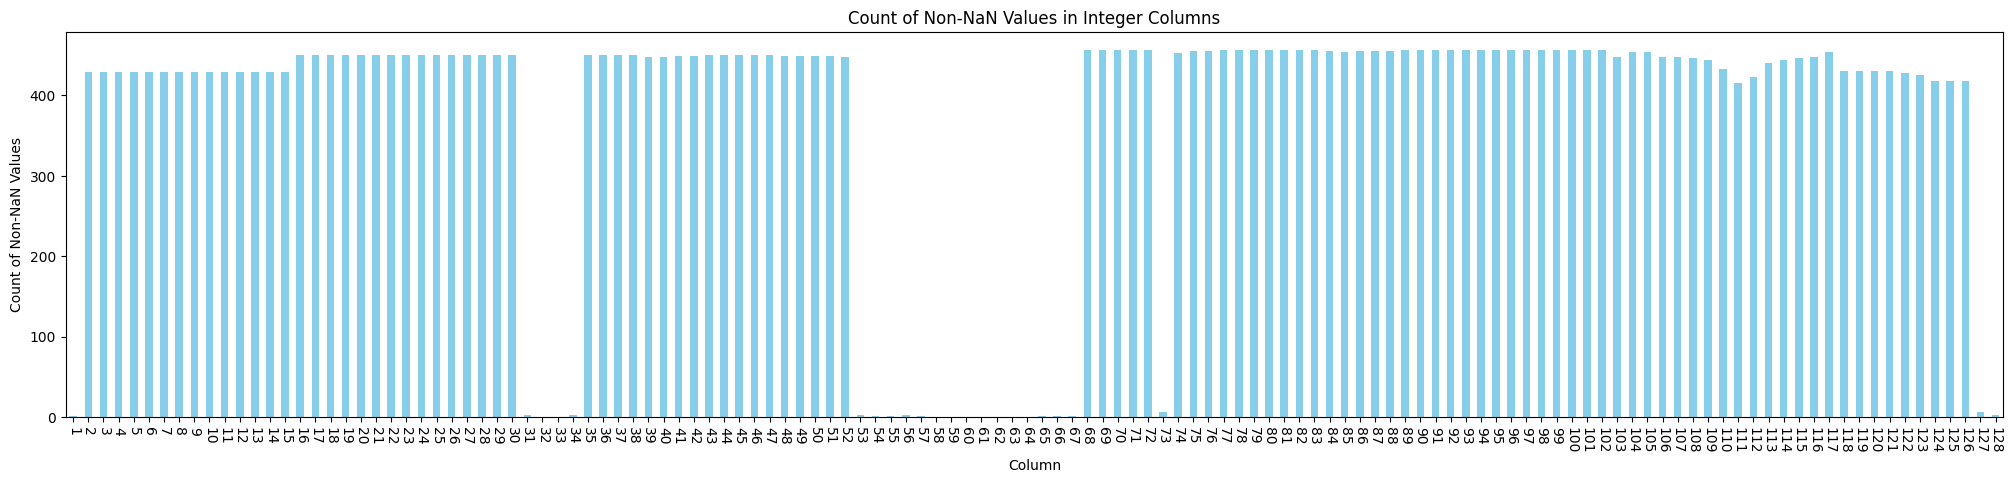

In [25]:
# Now plot the integer numbers and check we have got the start and identified the CDR2s
# Read the CSV file into a DataFrame
df = pd.read_csv("tmp/conditioned_results.csv")

# Assuming df is your DataFrame
# Select only integer columns
integer_columns = [col for col in df.columns if col.isdigit()]
df[integer_columns] = df[integer_columns].replace(['-', ' '], pd.NA)

# # Count non-NaN values in each integer column
non_nan_counts = df[integer_columns].notna().sum()

# Plotting the counts
plt.figure(figsize=(25, 5))
non_nan_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Non-NaN Values in Integer Columns')
plt.xlabel('Column')
plt.ylabel('Count of Non-NaN Values')
plt.xticks(rotation=-90)
plt.show()

In [34]:
# Let's check conserved residues
print("\n", df['104'].value_counts())
print("\n", df['23'].value_counts())
print("\n", df['41'].value_counts())


 104
C    441
A      7
S      6
Name: count, dtype: int64

 23
C    449
F      1
Name: count, dtype: int64

 41
W    449
Name: count, dtype: int64


In [37]:
# Are we finding the terminal GXGT?
print("\n", df['118'].value_counts().head(2))
print("\n", df['119'].value_counts().head(2))
print("\n", df['120'].value_counts().head(4))
print("\n", df['121'].value_counts().head(2))
print("\n", df['122'].value_counts().head(2))


 118
Y    277
C     93
Name: count, dtype: int64

 119
G    411
L      6
Name: count, dtype: int64

 120
G    236
D    155
A     15
R     10
Name: count, dtype: int64

 121
G    410
V      6
Name: count, dtype: int64

 122
T    402
E      8
Name: count, dtype: int64
